# Neural Machine Translation (NMT)

In the universe of natural language processing (NLP), text classification is a relatively simple task. At the opposite end of the difficulty spectrum lies neural machine translation (NMT), which uses deep learning to translate text from one language to another – for example, turning “Hello world” into “Salut le monde.” NMT has proven superior to the [rules-based machine translation](https://en.wikipedia.org/wiki/Rule-based_machine_translation) (RBMT) and [statistical machine translation](https://en.wikipedia.org/wiki/Statistical_machine_translation) (SMT) systems that predated the explosion of deep learning and today is the basis for virtually all state-of-the-art text-translation services. Let's use Keras and TensorFlow to build an NMT model that translates English to French.

The data file **en-fr.txt** is a subset of a [larger file](http://www.manythings.org/anki/fra-eng.zip) containing more than 190,000 phrases and their corresponding translations compiled as part of the [Tatoeba project](https://tatoeba.org/). The file is tab-delimited. Each line contains an English phrase, the equivalent French phrase, and an attribution identifying where the translation came from. We don’t need the attributions, so load the dataset into a Pandas DataFrame, remove the attribution column, and shuffle and reindex the rows.

In [1]:
import pandas as pd

df = pd.read_csv('Data/en-fr.txt', names=['en', 'fr', 'attr'], usecols=['en', 'fr'], sep='\t')
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)
df.head()

,en,fr
0,You're very clever.,Vous êtes fort ingénieuse.
1,Are there kids?,Y a-t-il des enfants ?
2,Come in.,Entrez !
3,Where's Boston?,Où est Boston ?
4,You see what I mean?,Vous voyez ce que je veux dire ?


Clean the text by removing punctuation symbols and numbers, converting characters to lowercase, and replacing Unicode characters with their ASCII equivalents:

In [2]:
import re
from unicodedata import normalize

def clean_text(text):
    text = normalize('NFD', text.lower())
    text = re.sub('[^A-Za-z ]+', '', text)
    return text

df['en'] = df['en'].apply(lambda row: clean_text(row))
df['fr'] = df['fr'].apply(lambda row: clean_text(row))
df.head()

,en,fr
0,youre very clever,vous etes fort ingenieuse
1,are there kids,y atil des enfants
2,come in,entrez
3,wheres boston,ou est boston
4,you see what i mean,vous voyez ce que je veux dire


The next step is to scan the phrases and determine the maximum length of the English phrases and then of the French phrases. These lengths will determine the lengths of the sequences input to and output from the model:

In [3]:
en = df['en']
fr = df['fr']

en_max_len = max(len(line.split()) for line in en)
fr_max_len = max(len(line.split()) for line in fr)

print(f'Max phrase length (English): {en_max_len}')
print(f'Max phrase length (French): {fr_max_len}')

Max phrase length (English): 7
Max phrase length (French): 14


Now fit one `Tokenizer` to the English phrases and another `Tokenizer` to their French equivalents, and generate padded sequences for all the phrases:

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

en_tokenizer = Tokenizer()
en_tokenizer.fit_on_texts(en)
en_sequences = en_tokenizer.texts_to_sequences(en)
en_x = pad_sequences(en_sequences, maxlen=en_max_len, padding='post')

fr_tokenizer = Tokenizer()
fr_tokenizer.fit_on_texts(fr)
fr_sequences = fr_tokenizer.texts_to_sequences(fr)
fr_y = pad_sequences(fr_sequences, maxlen=fr_max_len, padding='post')

Compute the vocabulary sizes from the `Tokenizer` instances:

In [5]:
en_vocab_size = len(en_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1

print(f'Vocabulary size (English): {en_vocab_size}')
print(f'Vocabulary size (French): {fr_vocab_size}')

Vocabulary size (English): 6033
Vocabulary size (French): 12195


## Build and train a model

Now it's time to define a model. We'll start with an `Embedding` layer followed by an `LSTM` layer that encodes English phrases input to the model. A second `LSTM` layer decodes those phrases into their French equivalents. In between is a `RepeatVector` layer whose purpose is to reshape the output from the first `LSTM` layer for input to the second. The final layer is a softmax classification layer that outputs probabilities for each word in the French vocabulary. The `TimeDistributed` wrapper ensures that the model outputs a set of probabilities for each token (word) in the output rather than just one set for the entire sequence.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, RepeatVector, TimeDistributed

model = Sequential()
model.add(Embedding(en_vocab_size, 128, input_length=en_max_len, mask_zero=True))
model.add(LSTM(128))
model.add(RepeatVector(fr_max_len))
model.add(LSTM(128, return_sequences=True))
model.add(TimeDistributed(Dense(fr_vocab_size, activation='softmax')))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.summary(line_length=100)

Model: "sequential"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 embedding (Embedding)                       (None, 7, 128)                          772224         
                                                                                                    
 lstm (LSTM)                                 (None, 128)                             131584         
                                                                                                    
 repeat_vector (RepeatVector)                (None, 14, 128)                         0              
                                                                                                    
 lstm_1 (LSTM)                               (None, 14, 128)                         131584         
                                                                       

Train the model:

In [7]:
hist = model.fit(en_x, fr_y, epochs=25, batch_size=50, validation_split=0.2)

Epoch 1/25
800/800 [==============================] - 90s 108ms/step - loss: 2.3555 - val_loss: 1.9356
Epoch 2/25
800/800 [==============================] - 85s 107ms/step - loss: 1.8734 - val_loss: 1.8350
Epoch 3/25
800/800 [==============================] - 84s 105ms/step - loss: 1.7625 - val_loss: 1.7353
Epoch 4/25
800/800 [==============================] - 86s 107ms/step - loss: 1.6376 - val_loss: 1.6198
Epoch 5/25
800/800 [==============================] - 86s 108ms/step - loss: 1.5036 - val_loss: 1.5069
Epoch 6/25
800/800 [==============================] - 88s 110ms/step - loss: 1.3827 - val_loss: 1.4185
Epoch 7/25
800/800 [==============================] - 88s 110ms/step - loss: 1.2798 - val_loss: 1.3506
Epoch 8/25
800/800 [==============================] - 89s 111ms/step - loss: 1.1905 - val_loss: 1.2977
Epoch 9/25
800/800 [==============================] - 88s 110ms/step - loss: 1.1098 - val_loss: 1.2508
Epoch 10/25
800/800 [==============================] - 89s 112ms/step - l

Plot the per-epoch training and validation loss:

[]

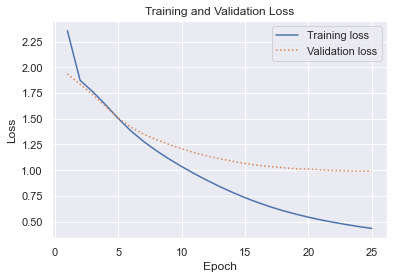

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, '-', label='Training loss')
plt.plot(epochs, val_loss, ':', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.plot()

## Use the model to translate text

Can the model really translate English to French? Use a subset of the phrases reserved to validate the model to make predictions and see for yourself. Note the use of the French `Tokenizer`’s `sequences_to_texts` method to convert sequences representing French phrases predicted by the model into words:

In [9]:
import numpy as np

texts = en[40000:40010].values
sequences = en_tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=en_max_len, padding='post')
predictions = model.predict(padded_sequences)

for i in range(len(predictions)):
    indexes = [np.argmax(idx) for idx in predictions[i]]
    translated_text = fr_tokenizer.sequences_to_texts([indexes])[0]
    print(f'{texts[i]} => {translated_text}')

its fall now => cest maintenant maintenant maintenant
im losing => je suis train
it was quite funny => cetait plutot amusant amusant
thats not unusual => ce nest pas inhabituel
i think ill do that => je pense que je cela
tom looks different => tom a lair different
its worth a try => ca vaut le dessayer dessayer
fortune smiled on him => la chance sest a
lets hit the road => cassonsnous
i love winning => jadore lemporter


Finally, see how the model translates "Hello world" into French:

In [10]:
text = 'Hello world'
sequence = en_tokenizer.texts_to_sequences([text])
padded_sequence = pad_sequences(sequence, maxlen=en_max_len, padding='post')
prediction = model.predict(padded_sequence)[0]
indexes = [np.argmax(idx) for idx in prediction]
fr_tokenizer.sequences_to_texts([indexes])

['salut le monde']

The model isn't perfect, but it's not bad, either. The vocabularies that you trained with are relatively small, but if you expanded the vocabularies and deepened the model – for example, if you included two `LSTM` layers for encoding and two for decoding – you'd have the makings of a fine NMT model.